In [ ]:
print('\nBegin Part - Imports\n')

import datetime as dt
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout 
from keras.models import Sequential, load_model 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statistics
import tensorflow as tf
import time

total_run_time_start_time = dt.datetime.now()
print('Start time: ' + str(dt.datetime.now()))

# Specify the GPU to use
gpu_number = str(0)

os.environ["CUDA_VISIBLE_DEVICES"]=gpu_number

print('\nFinished - Imports.  Ready to move to next cell.')



Begin Part - Imports

Start time: 2021-12-04 03:35:34.805714

Finished - Imports.  Ready to move to next cell.


In [ ]:
# Cell 2

# Set initial variables
print('\nBegin Part - Set variables\n')

# Set train_YN to Y if actual training needs to be done.  If just runnin against the test set,
# then set to N.
train_YN = 'Y'

# Set initial_path
initial_path = ''

# Determine if data should be plotted
plot_data = 'Y' # Values are Y or N
data_file = 'datacgm2-processed.csv'
# Set value of how many records to use depending on training set size
train_record_number = 3516

# Set value of how many records to use depending on test set size
test_record_number = 938

# Number of epochs to run
num_epochs = 100
# Batch size
training_batch_size = 32
# Set initial loss value to 0.  This is needed for printing the graph if training is not run.
loss = 0

# Model file
model_file = 'MODEL' + '-' + str(num_epochs) + '-' + gpu_number + '.h5'

print('\nFinished Part - Set variables.  Ready to move to next cell.')


Begin Part - Set variables


Finished Part - Set variables.  Ready to move to next cell.


In [ ]:
# Open the processed files as the input files

data_df = pd.read_csv(str(data_file), index_col=False)
data_df = data_df.iloc[::-1].reset_index()
data_df = data_df.replace('',np.nan)
data_df = data_df.dropna(axis="rows", how="any")
hour_date=[]  

print(hour_date)
# print(data_old)
print(data_df.head())
means_data = data_df['Glucose'].groupby([data_df['Date'], data_df['Hour']]).mean()
print((means_data))

[]
   index         DateTime  Glucose       Date  Hour
0  55342  7/25/2017 12:08    314.0  7/25/2017    12
1  55341  7/25/2017 12:13    310.0  7/25/2017    12
2  55340  7/25/2017 12:18    309.0  7/25/2017    12
3  55339  7/25/2017 12:23    311.0  7/25/2017    12
4  55338  7/25/2017 12:28    311.0  7/25/2017    12
Date      Hour
1/1/2018  0       141.750000
          1       154.166667
          2       150.750000
          3       149.166667
          4       105.916667
                     ...    
9/9/2017  19      167.583333
          20      175.666667
          21      107.750000
          22       62.750000
          23       57.333333
Name: Glucose, Length: 4394, dtype: float64



Begin Part 8 of 19 - Plot train and test data



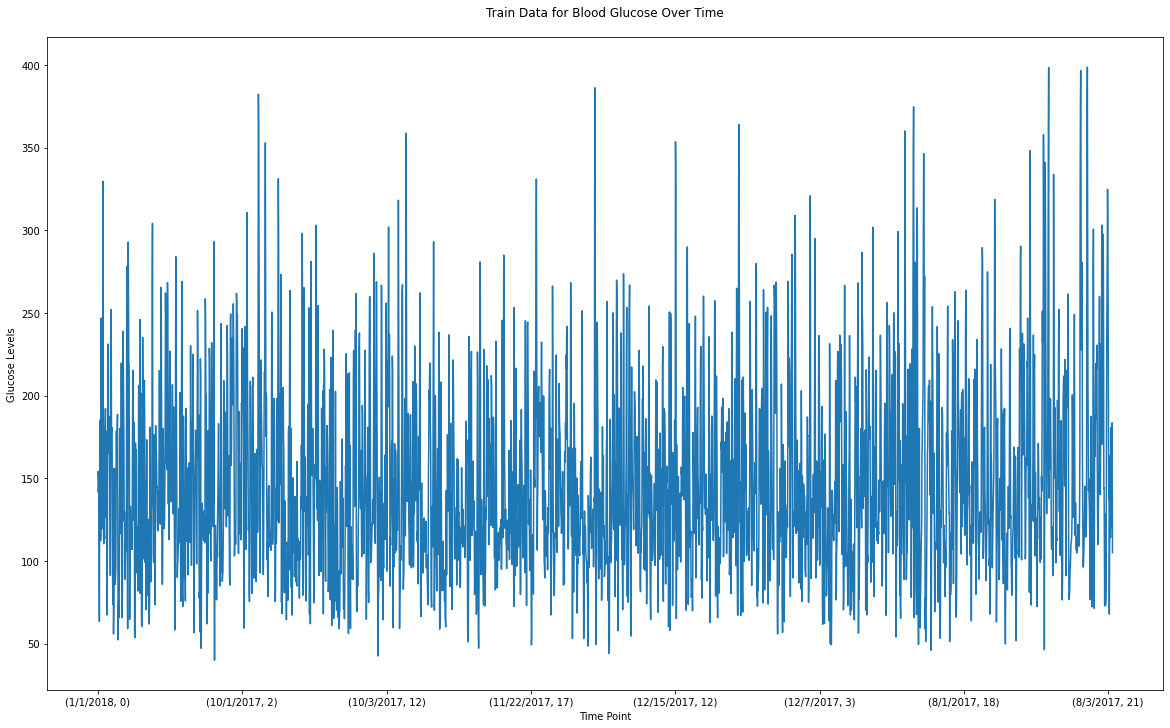

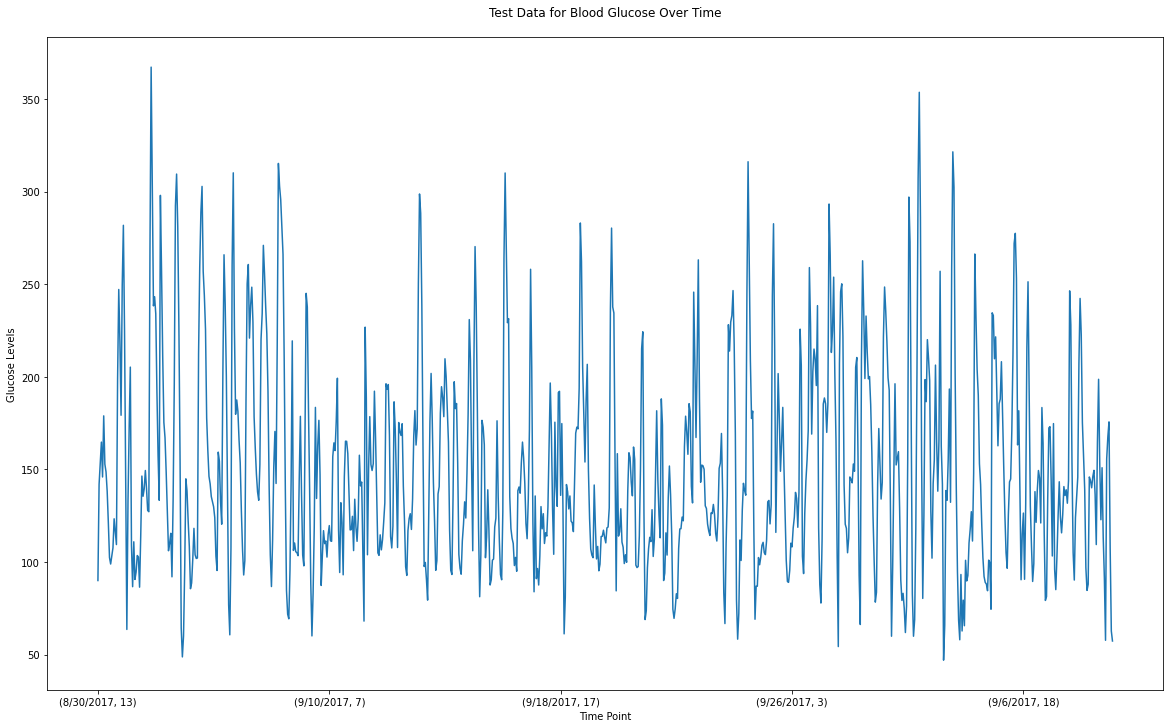

In [ ]:
# Plot test and train data
if(plot_data == 'Y'):
  plt.figure(figsize=(20,12))
  means_data[:train_record_number].plot(kind='line', title='Train Data for Blood Glucose Over Time\n')
  plt.xlabel('Time Point')  
  plt.ylabel('Glucose Levels')
  plt.show()
  print('\n\n\n\n')
  plt.figure(figsize=(20,12))
  means_data[train_record_number:len(data_df)].plot(kind='line', title='Test Data for Blood Glucose Over Time\n')
  plt.xlabel('Time Point')  
  plt.ylabel('Glucose Levels')
  plt.show()



In [ ]:
print('Begin adding elements to train_glucose_df')   
train_glucose_df = pd.DataFrame(columns=['Date_Hour', 'Glucose_Level'])
for i in range(0, 3516):
  temp_date = means_data.index[[i][0]]
  temp_date_hour = str(temp_date[0]) + ':' + str(temp_date[1])
  train_glucose_level = means_data[[i][0]]
  train_glucose_df.loc[len(train_glucose_df)] = [temp_date_hour, train_glucose_level]
print('Finished adding elements to train_glucose_df')  

print('Begin adding elements to test_glucose_df')  
test_glucose_df = pd.DataFrame(columns=['Date_Hour', 'Glucose_Level'])
for i in range(3516,4394):
  temp_date = means_data.index[[i][0]]
  temp_date_hour = str(temp_date[0]) + ':' + str(temp_date[1])
  test_glucose_level = means_data[[i][0]]
  test_glucose_df.loc[len(test_glucose_df)] = [temp_date_hour, test_glucose_level]
print('Finished adding elements to test_glucose_df')    

print('\nFinished Part- Add elements to train_glucose_df and test_glucose_df.  Ready to move to next cell.')

Begin adding elements to train_glucose_df
Finished adding elements to train_glucose_df
Begin adding elements to test_glucose_df
Finished adding elements to test_glucose_df

Finished Part- Add elements to train_glucose_df and test_glucose_df.  Ready to move to next cell.


In [ ]:
# Begin LSTM
# Scale training set
glucose_training_set = train_glucose_df.iloc[:,1:2].values
# Feature scaling
scaler = MinMaxScaler(feature_range = (0,1))
glucose_training_set_scaled = scaler.fit_transform(glucose_training_set)

print('\nFinished Part- Scale training set.  Ready to move to next cell.')


Finished Part- Scale training set.  Ready to move to next cell.


In [ ]:

# Begin prepping training set
features_set = []  
labels = []  

for i in range(60, train_record_number):  
    # Original
    #features_set.append(glucose_training_set_scaled[i-60:i, 0])
    # Updated (Get values from 0-59 to use as the value to predict 60)
    features_set.append(glucose_training_set_scaled[i-60:i, 0])
    labels.append(glucose_training_set_scaled[i, 0])

    
print('\nFinished Part - Prep training set.  Ready to move to next cell.')


Finished Part - Prep training set.  Ready to move to next cell.


# New Section

In [ ]:
# Reshape training set

features_set, labels = np.array(features_set), np.array(labels)

features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

print('\nFinished Part - Reshape training set.  Ready to move to next cell.')


Finished Part - Reshape training set.  Ready to move to next cell.


In [ ]:
# Build LSTM model
# This only needs to be done if train_YN == Y
if train_YN == 'Y':
  print('\nBegin - Build LSTM\n')

  model = Sequential() 

  model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))  
  model.add(Dropout(0.2))  
  model.add(LSTM(units=50, return_sequences=True))  
  model.add(Dropout(0.2))

  model.add(LSTM(units=50, return_sequences=True))  
  model.add(Dropout(0.2))

  model.add(LSTM(units=50))  
  model.add(Dropout(0.2)) 

  model.add(Dense(units = 1))  

  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  print('\nFinished Part- Build LSTM.  Ready to move to next cell.')


Begin - Build LSTM


Finished Part- Build LSTM.  Ready to move to next cell.


In [ ]:

# Create model
# This only needs to be done if train_YN == Y
if train_YN == 'Y':
    
  # Get start time for training
  training_start_time = dt.datetime.now()
    
  print('\nBegin Part 14 of 19 - Create model\n')
  from keras.callbacks import EarlyStopping

  # Patient early stopping
  es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

  history = model.fit(features_set, labels, epochs = num_epochs, batch_size = training_batch_size, callbacks = [es])  

  loss = model.evaluate(features_set, labels, verbose=0)
  print('\nUnscaled Loss = ' + str(loss))
  #print('\nScaled Loss = ' + str(scaler.inverse_transform(loss)))


  #######
  # Save model
  model.save(str(initial_path + model_file))

  # Get end time for training
  training_end_time = dt.datetime.now()

  # Calculate total training time
  training_total_time = str((training_end_time-training_start_time).total_seconds()) + ' seconds.'

  print('\n\nTotal training time ' + training_total_time)

  print('\nFinished Part - Create model.  Ready to move to next cell.')


Begin Part 14 of 19 - Create model

Epoch 1/100
108/108 [==============================] - 17s 104ms/step - loss: 0.0271
Epoch 2/100
108/108 [==============================] - 11s 103ms/step - loss: 0.0247
Epoch 3/100
108/108 [==============================] - 11s 103ms/step - loss: 0.0246
Epoch 4/100
108/108 [==============================] - 11s 103ms/step - loss: 0.0242
Epoch 5/100
108/108 [==============================] - 11s 102ms/step - loss: 0.0241
Epoch 6/100
108/108 [==============================] - 11s 103ms/step - loss: 0.0243
Epoch 7/100
108/108 [==============================] - 11s 104ms/step - loss: 0.0239
Epoch 8/100
108/108 [==============================] - 11s 103ms/step - loss: 0.0240
Epoch 9/100
108/108 [==============================] - 11s 104ms/step - loss: 0.0240
Epoch 10/100
108/108 [==============================] - 11s 103ms/step - loss: 0.0238
Epoch 11/100
108/108 [==============================] - 11s 105ms/step - loss: 0.0239
Epoch 12/100
108/108 [====

In [ ]:
# Cell 12

# Concat train and test to be able to do run testing
print('\nBegin Part 15 of 19 - Concat train and test\n')
print(test_glucose_df)
glucose_total = pd.DataFrame(columns=['Glucose_Level'])

glucose_total = pd.concat((train_glucose_df['Glucose_Level'], test_glucose_df['Glucose_Level']), axis=0) 

print('\nFinished Part 15 of 19 - Concat train and test.  Ready to move to next cell.')


Begin Part 15 of 19 - Concat train and test

        Date_Hour  Glucose_Level
0    8/30/2017:13      90.000000
1    8/30/2017:14     141.916667
2    8/30/2017:15     153.750000
3    8/30/2017:16     164.750000
4    8/30/2017:17     145.916667
..            ...            ...
873   9/9/2017:19     167.583333
874   9/9/2017:20     175.666667
875   9/9/2017:21     107.750000
876   9/9/2017:22      62.750000
877   9/9/2017:23      57.333333

[878 rows x 2 columns]

Finished Part 15 of 19 - Concat train and test.  Ready to move to next cell.


In [ ]:
#Reshape test shape
print('\nBegin Part - Reshape test set\n')

test_inputs = glucose_total[len(train_glucose_df) - 60:].values 

test_inputs = test_inputs.reshape(-1,1)  
test_inputs = scaler.transform(test_inputs)

print('\nFinished Part - Reshape test set.')


Begin Part - Reshape test set


Finished Part - Reshape test set.


In [ ]:
#Prep test set
print('\nBegin Part - Prep test set\n')
#print(len(test_inputs))
test_features = []  
for i in range(60, test_record_number):  
    test_features.append(test_inputs[i-60:i, 0])
    
test_features = np.array(test_features)  
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))      

print('\nFinished Part - Prep test set.')


Begin Part - Prep test set


Finished Part - Prep test set.


In [ ]:
#Predictions
print('\nBegin Part - Predictions\n')

# Get start time for inference
inf_start_time = dt.datetime.now()

model = load_model(str(initial_path + model_file))

predictions = model.predict(test_features)  

#Inverse transform predictions
predictions = scaler.inverse_transform(predictions)

actual_predicted_difference_list = []

for i in range(0,len(predictions)):
    print('\nActual value for ' + str(test_glucose_df.loc[i,'Date_Hour']) + ' = ' 
          + str(test_glucose_df.loc[i,'Glucose_Level']))
    print('Predicted value = {0}'.format(predictions[i,0]))

    # Calculate mean square error
    actual_predicted_difference_list.append((predictions[i,0] - test_glucose_df.loc[i,'Glucose_Level']) ** 2)

mean_square = statistics.mean(actual_predicted_difference_list)
print('Mean square error = ' + str(mean_square))

# Get end time for inference
inf_end_time = dt.datetime.now()

# Calculate total inference time
inf_total_time = str((inf_end_time-inf_start_time).total_seconds()) + ' seconds.'

print('\n\nTotal inference time ' + inf_total_time)

print('\nFinished Part - Predictions.  Ready to move to next cell.')


Begin Part - Predictions


Actual value for 8/30/2017:13 = 90.0
Predicted value = 90.85352325439453

Actual value for 8/30/2017:14 = 141.91666666666666
Predicted value = 160.68545532226562

Actual value for 8/30/2017:15 = 153.75
Predicted value = 202.1350860595703

Actual value for 8/30/2017:16 = 164.75
Predicted value = 178.391357421875

Actual value for 8/30/2017:17 = 145.91666666666666
Predicted value = 237.92210388183594

Actual value for 8/30/2017:18 = 178.91666666666666
Predicted value = 179.71644592285156

Actual value for 8/30/2017:19 = 152.83333333333334
Predicted value = 289.37255859375

Actual value for 8/30/2017:20 = 148.66666666666666
Predicted value = 173.86444091796875

Actual value for 8/30/2017:21 = 138.16666666666666
Predicted value = 199.0651397705078

Actual value for 8/30/2017:22 = 121.25
Predicted value = 172.2861328125

Actual value for 8/30/2017:23 = 102.41666666666667
Predicted value = 145.61102294921875

Actual value for 8/31/2017:0 = 98.91666666666667
Predic


Begin Part - Plot predictions
878


Plotting predictions


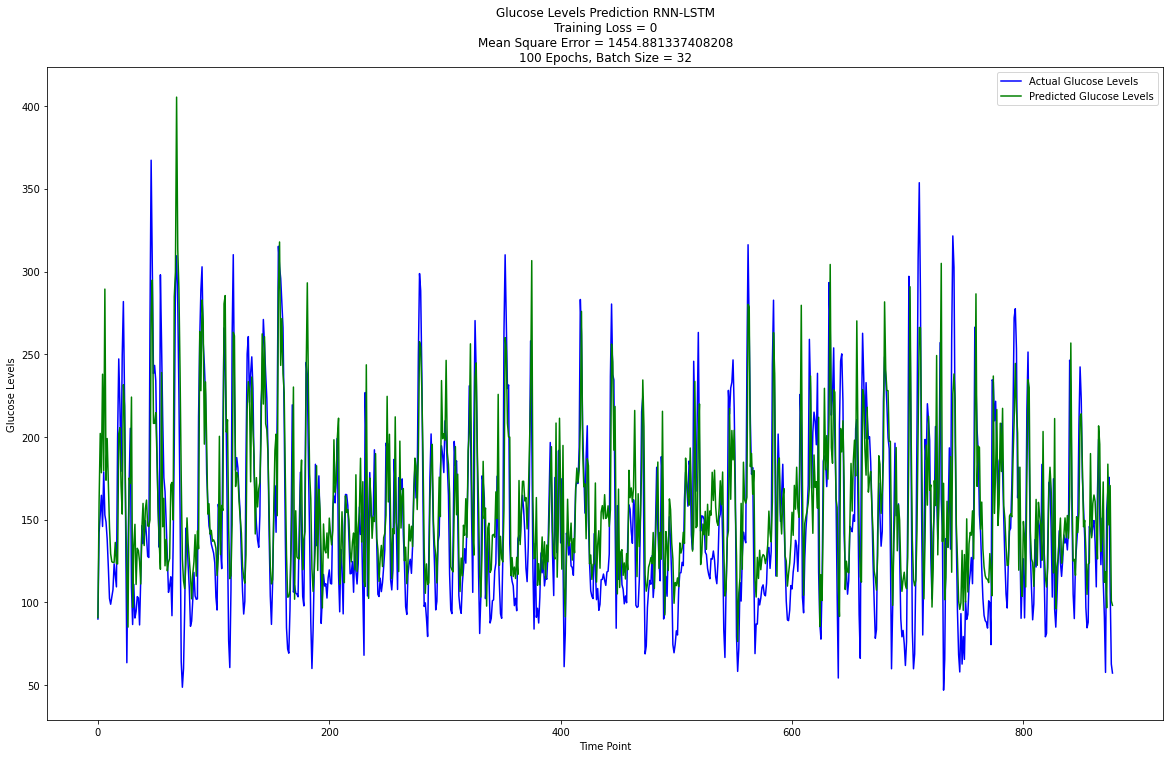


Finished Part - Plot predictions.


In [ ]:
#Plot predictions
print('\nBegin Part - Plot predictions')

actual = test_glucose_df['Glucose_Level'].values
actual = actual[0:len(test_glucose_df)]

print(len(predictions))

plot_data = 'Y' # Values are Y or N

print('\n\nPlotting predictions')
plt.figure(figsize=(20,12))  
plt.plot(actual, color='blue', label='Actual Glucose Levels')  
plt.plot(predictions , color='green', label='Predicted Glucose Levels')  
plt.title('Glucose Levels Prediction RNN-LSTM' + '\nTraining Loss = ' +
         str(loss) + '\nMean Square Error = ' + str(mean_square) + '\n' + str(num_epochs) + ' Epochs, ' +
         'Batch Size = ' + str(training_batch_size))  
plt.xlabel('Time Point')  
plt.ylabel('Glucose Levels')  
plt.legend()  
plt.show() 

print('\nFinished Part - Plot predictions.')




# New Section

In [ ]:
# Cell 17

total_run_time_end_time = dt.datetime.now()

print('Training Loss = ' + str(loss))
print('Mean Square Error = ' + str(mean_square))

#print('\n\nTotal training time ' + training_total_time)

print('\n\nTotal inference time ' + inf_total_time)

print('\n\nTotal run time ' + str((total_run_time_end_time-total_run_time_start_time).total_seconds()) + ' seconds.')


Training Loss = 0
Mean Square Error = 1454.881337408208


Total inference time 4.082347 seconds.


Total run time 2501.220738 seconds.
